# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import geometry as geo
import geostrophy as geost
import cyclogeostrophy as cyclo

%reload_ext autoreload
%autoreload 2

# Reading data

## Parameters

In [2]:
dir_data = '/home/viannazv/notebooks/Data/Data1/'
name_mask = 'mask_eNATL60MEDWEST_3.6.nc'
name_coord = 'coordinates_eNATL60MEDWEST.nc'
name_ssh = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc'
name_u = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc'
name_v = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc'

#dir_data = '/home/viannazv/notebooks/Data/Data2/'
#name_ssh = 'NATLORCA12.L75-GJM2020_y2015m12d31.1d_gridT.nc'
#name_u = 'NATLORCA12.L75-GJM2020_y2015m12d31.1d_gridU.nc'
#name_v = 'NATLORCA12.L75-GJM2020_y2015m12d31.1d_gridV.nc'

## Opening data

In [3]:
ds_coord = xr.open_dataset(dir_data+name_coord)
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(dir_data+name_mask)
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(dir_data+name_ssh)
#print(ds_ssh)
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(dir_data+name_u)
#print(ds_u)
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(dir_data+name_v)
#print(ds_v)
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

## Ploting the data

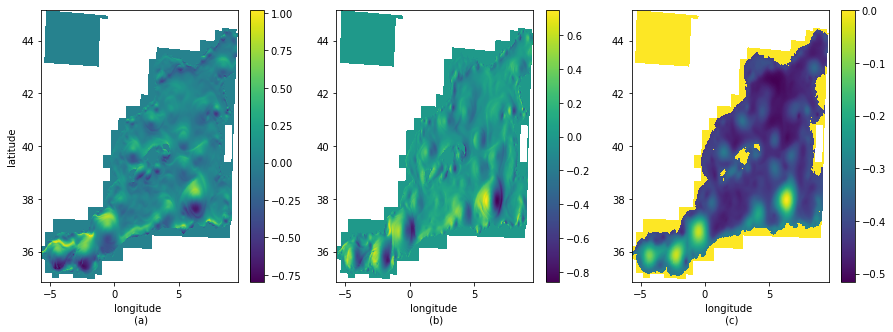

In [4]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, uvel,shading='auto')
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon, lat,vvel,shading='auto')
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,ssh,shading='auto')
plt.colorbar(im,ax=ax3)
plt.show()

## Create arrays of spatial steps

These dx and dy steps must be used to compute derivatives.

In [5]:
dx_ssh, dy_ssh = geo.compute_spatial_steps(lon_ssh, lat_ssh)
dx_u, dy_u = geo.compute_spatial_steps(lon_u, lat_u)
dx_v, dy_v = geo.compute_spatial_steps(lon_v, lat_v)

 ## Spliting the data for the geostrophy

In [6]:
x1 =180
x2 = -480
y1 = 500
y2 = -100

# Reduced grid for testing
#x1 =180
#x2 = -615
#y1 = 500
#y2 = -375

ssh = ssh[x1 : x2, y1 : y2]
lat_ssh = lat_ssh[x1 : x2, y1 : y2]
lon_ssh = lon_ssh[x1 : x2, y1 : y2]
dx_ssh = dx_ssh[x1 : x2, y1 : y2]
dy_ssh = dy_ssh[x1 : x2, y1 : y2]

uvel = uvel[x1 : x2, y1 : y2]
lat_u = lat_u[x1 : x2, y1 : y2]
lon_u = lon_u[x1 : x2, y1 : y2]
dx_u = dx_u[x1 : x2, y1 : y2]
dy_u = dy_u[x1 : x2, y1 : y2]

vvel = vvel[x1 : x2, y1 : y2]
lat_v = lat_v[x1 : x2, y1 : y2]
lon_v = lon_v[x1 : x2, y1 : y2]
dx_v = dx_v[x1 : x2, y1 : y2]
dy_v = dy_v[x1 : x2, y1 : y2]

lon = lon[x1 : x2, y1 : y2]
lat = lat[x1 : x2, y1 : y2]

## Ploting the split data

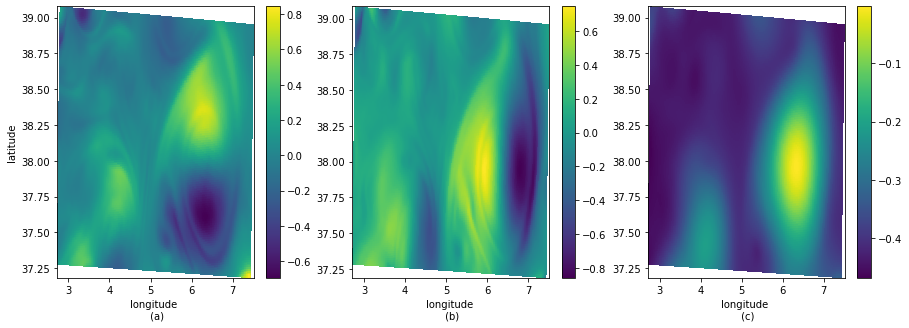

In [7]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel,shading='auto')
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,vvel,shading='auto')
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_ssh, lat_ssh,ssh,shading='auto')
plt.colorbar(im,ax=ax3)
plt.show()

## Plotting the C-Grid"

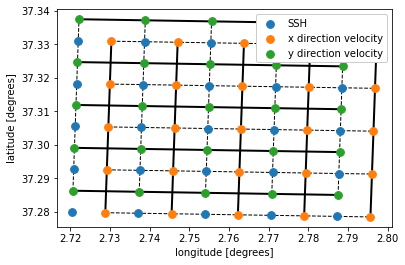

In [8]:
fig = geo.PlotGrid(lon_ssh, lat_ssh, lon_u, lat_u, lon_v, lat_v)

# Input data

In [9]:
gravity = 9.81
coriolis_factor_ssh = 2 * 7.2722e-05 * np.sin(lat_ssh * np.pi / 180)
coriolis_factor_u = 2 * 7.2722e-05 * np.sin(lat_u * np.pi / 180)
coriolis_factor_v = 2 * 7.2722e-05 * np.sin(lat_v * np.pi / 180)

# Geostrophic  balance

In [10]:
u_geos, v_geos = geost.geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

## Ploting the u_geos and v_geos

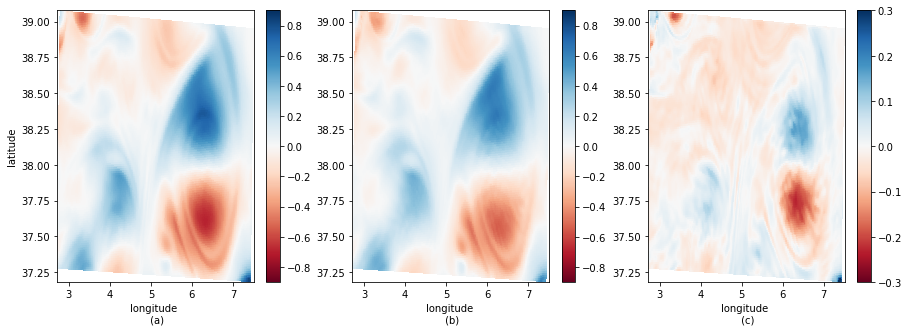

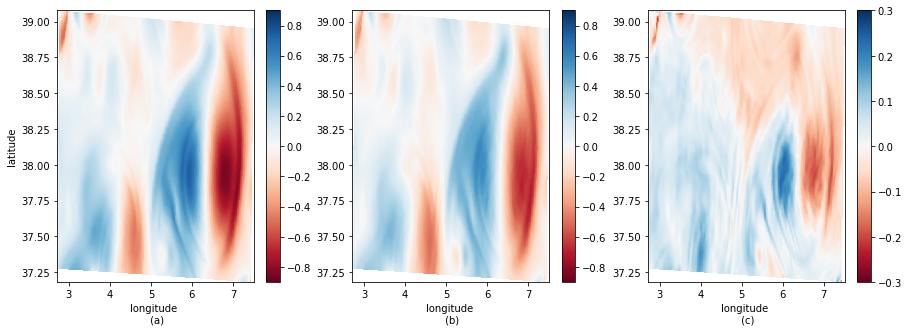

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, uvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,u_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,uvel-u_geos, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, vvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,v_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,vvel-v_geos, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

# Cyclogeostrophic balance

In [12]:
# Input values for the loss function
u = np.copy(u_geos)
v = np.copy(v_geos)

## Defining the cost function

In [13]:
def loss(u,v):
    J_u = np.sum((u + geo.compute_advection_v_jax(u, v, dx_v, dy_v)/coriolis_factor_u - u_geos)**2)
    J_v = np.sum((v - geo.compute_advection_u_jax(u, v, dx_u, dy_u)/coriolis_factor_v - v_geos)**2)
    return J_u + J_v
    
# Initial loss
loss(u,v)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(71.28865, dtype=float32)

## Computing the cyclogeostrophy - Minimization method

In [14]:
# run gradient descent to minimize f
u_min, v_min = cyclo.gradient_descent_jax(loss,u,v)

iteration 1: loss(x, y) = 69.37957000732422
iteration 2: loss(x, y) = 67.7740707397461
iteration 3: loss(x, y) = 66.36563110351562
iteration 4: loss(x, y) = 65.09526062011719
iteration 5: loss(x, y) = 63.92731475830078
iteration 6: loss(x, y) = 62.83879852294922
iteration 7: loss(x, y) = 61.814178466796875
iteration 8: loss(x, y) = 60.84246826171875
iteration 9: loss(x, y) = 59.9156379699707
iteration 10: loss(x, y) = 59.02760696411133
iteration 11: loss(x, y) = 58.1737060546875
iteration 12: loss(x, y) = 57.35020446777344
iteration 13: loss(x, y) = 56.55409622192383
iteration 14: loss(x, y) = 55.78291702270508
iteration 15: loss(x, y) = 55.034584045410156
iteration 16: loss(x, y) = 54.30736541748047
iteration 17: loss(x, y) = 53.5997428894043
iteration 18: loss(x, y) = 52.910438537597656
iteration 19: loss(x, y) = 52.238304138183594
iteration 20: loss(x, y) = 51.58233642578125
iteration 21: loss(x, y) = 50.94166564941406
iteration 22: loss(x, y) = 50.315460205078125
iteration 23: loss

iteration 181: loss(x, y) = 11.808906555175781
iteration 182: loss(x, y) = 11.719356536865234
iteration 183: loss(x, y) = 11.63062572479248
iteration 184: loss(x, y) = 11.542708396911621
iteration 185: loss(x, y) = 11.45559310913086
iteration 186: loss(x, y) = 11.369279861450195
iteration 187: loss(x, y) = 11.2837495803833
iteration 188: loss(x, y) = 11.198997497558594
iteration 189: loss(x, y) = 11.115015983581543
iteration 190: loss(x, y) = 11.0317964553833
iteration 191: loss(x, y) = 10.94933032989502
iteration 192: loss(x, y) = 10.867612838745117
iteration 193: loss(x, y) = 10.786629676818848
iteration 194: loss(x, y) = 10.706376075744629
iteration 195: loss(x, y) = 10.626850128173828
iteration 196: loss(x, y) = 10.548032760620117
iteration 197: loss(x, y) = 10.469927787780762
iteration 198: loss(x, y) = 10.3925199508667
iteration 199: loss(x, y) = 10.315805435180664
iteration 200: loss(x, y) = 10.239776611328125
iteration 201: loss(x, y) = 10.16442584991455
iteration 202: loss(x, 

iteration 359: loss(x, y) = 3.599607467651367
iteration 360: loss(x, y) = 3.578669548034668
iteration 361: loss(x, y) = 3.557884693145752
iteration 362: loss(x, y) = 3.5372490882873535
iteration 363: loss(x, y) = 3.5167641639709473
iteration 364: loss(x, y) = 3.496426582336426
iteration 365: loss(x, y) = 3.476236581802368
iteration 366: loss(x, y) = 3.4561920166015625
iteration 367: loss(x, y) = 3.436291456222534
iteration 368: loss(x, y) = 3.416534423828125
iteration 369: loss(x, y) = 3.3969199657440186
iteration 370: loss(x, y) = 3.377446174621582
iteration 371: loss(x, y) = 3.3581113815307617
iteration 372: loss(x, y) = 3.338916063308716
iteration 373: loss(x, y) = 3.3198578357696533
iteration 374: loss(x, y) = 3.3009355068206787
iteration 375: loss(x, y) = 3.282148599624634
iteration 376: loss(x, y) = 3.263495922088623
iteration 377: loss(x, y) = 3.244976043701172
iteration 378: loss(x, y) = 3.2265875339508057
iteration 379: loss(x, y) = 3.2083303928375244
iteration 380: loss(x, y)

iteration 537: loss(x, y) = 1.442776083946228
iteration 538: loss(x, y) = 1.436331033706665
iteration 539: loss(x, y) = 1.4299249649047852
iteration 540: loss(x, y) = 1.423556923866272
iteration 541: loss(x, y) = 1.4172271490097046
iteration 542: loss(x, y) = 1.410935401916504
iteration 543: loss(x, y) = 1.4046812057495117
iteration 544: loss(x, y) = 1.3984644412994385
iteration 545: loss(x, y) = 1.392284631729126
iteration 546: loss(x, y) = 1.3861415386199951
iteration 547: loss(x, y) = 1.380035400390625
iteration 548: loss(x, y) = 1.3739652633666992
iteration 549: loss(x, y) = 1.3679314851760864
iteration 550: loss(x, y) = 1.3619333505630493
iteration 551: loss(x, y) = 1.3559709787368774
iteration 552: loss(x, y) = 1.350043773651123
iteration 553: loss(x, y) = 1.3441516160964966
iteration 554: loss(x, y) = 1.338294506072998
iteration 555: loss(x, y) = 1.3324718475341797
iteration 556: loss(x, y) = 1.3266836404800415
iteration 557: loss(x, y) = 1.3209295272827148
iteration 558: loss(x

iteration 716: loss(x, y) = 0.7187474966049194
iteration 717: loss(x, y) = 0.7163558006286621
iteration 718: loss(x, y) = 0.7139760255813599
iteration 719: loss(x, y) = 0.7116082906723022
iteration 720: loss(x, y) = 0.7092528343200684
iteration 721: loss(x, y) = 0.7069091796875
iteration 722: loss(x, y) = 0.7045773267745972
iteration 723: loss(x, y) = 0.7022573947906494
iteration 724: loss(x, y) = 0.6999490261077881
iteration 725: loss(x, y) = 0.6976525187492371
iteration 726: loss(x, y) = 0.6953672170639038
iteration 727: loss(x, y) = 0.6930937767028809
iteration 728: loss(x, y) = 0.6908316612243652
iteration 729: loss(x, y) = 0.6885809898376465
iteration 730: loss(x, y) = 0.6863415241241455
iteration 731: loss(x, y) = 0.6841133832931519
iteration 732: loss(x, y) = 0.6818963289260864
iteration 733: loss(x, y) = 0.6796904802322388
iteration 734: loss(x, y) = 0.6774955987930298
iteration 735: loss(x, y) = 0.675311803817749
iteration 736: loss(x, y) = 0.6731388568878174
iteration 737: lo

iteration 891: loss(x, y) = 0.4361608624458313
iteration 892: loss(x, y) = 0.4351138770580292
iteration 893: loss(x, y) = 0.43407148122787476
iteration 894: loss(x, y) = 0.4330335855484009
iteration 895: loss(x, y) = 0.43200019001960754
iteration 896: loss(x, y) = 0.4309713542461395
iteration 897: loss(x, y) = 0.42994701862335205
iteration 898: loss(x, y) = 0.4289270043373108
iteration 899: loss(x, y) = 0.4279114603996277
iteration 900: loss(x, y) = 0.42690038681030273
iteration 901: loss(x, y) = 0.4258935749530792
iteration 902: loss(x, y) = 0.4248911738395691
iteration 903: loss(x, y) = 0.4238930940628052
iteration 904: loss(x, y) = 0.42289936542510986
iteration 905: loss(x, y) = 0.421909898519516
iteration 906: loss(x, y) = 0.42092469334602356
iteration 907: loss(x, y) = 0.41994374990463257
iteration 908: loss(x, y) = 0.41896694898605347
iteration 909: loss(x, y) = 0.4179943799972534
iteration 910: loss(x, y) = 0.41702592372894287
iteration 911: loss(x, y) = 0.4160618185997009
itera

iteration 1064: loss(x, y) = 0.3068509101867676
iteration 1065: loss(x, y) = 0.3063315749168396
iteration 1066: loss(x, y) = 0.30581411719322205
iteration 1067: loss(x, y) = 0.30529868602752686
iteration 1068: loss(x, y) = 0.3047851026058197
iteration 1069: loss(x, y) = 0.30427342653274536
iteration 1070: loss(x, y) = 0.3037636876106262
iteration 1071: loss(x, y) = 0.3032558262348175
iteration 1072: loss(x, y) = 0.3027498126029968
iteration 1073: loss(x, y) = 0.3022457957267761
iteration 1074: loss(x, y) = 0.30174362659454346
iteration 1075: loss(x, y) = 0.3012431859970093
iteration 1076: loss(x, y) = 0.30074477195739746
iteration 1077: loss(x, y) = 0.30024805665016174
iteration 1078: loss(x, y) = 0.2997532784938812
iteration 1079: loss(x, y) = 0.29926031827926636
iteration 1080: loss(x, y) = 0.29876911640167236
iteration 1081: loss(x, y) = 0.2982797622680664
iteration 1082: loss(x, y) = 0.2977921962738037
iteration 1083: loss(x, y) = 0.2973064184188843
iteration 1084: loss(x, y) = 0.2

iteration 1234: loss(x, y) = 0.2405407726764679
iteration 1235: loss(x, y) = 0.24025273323059082
iteration 1236: loss(x, y) = 0.23996557295322418
iteration 1237: loss(x, y) = 0.23967933654785156
iteration 1238: loss(x, y) = 0.23939402401447296
iteration 1239: loss(x, y) = 0.2391095757484436
iteration 1240: loss(x, y) = 0.23882606625556946
iteration 1241: loss(x, y) = 0.23854343593120575
iteration 1242: loss(x, y) = 0.23826172947883606
iteration 1243: loss(x, y) = 0.2379809021949768
iteration 1244: loss(x, y) = 0.23770096898078918
iteration 1245: loss(x, y) = 0.2374219000339508
iteration 1246: loss(x, y) = 0.23714375495910645
iteration 1247: loss(x, y) = 0.23686647415161133
iteration 1248: loss(x, y) = 0.23659002780914307
iteration 1249: loss(x, y) = 0.2363145351409912
iteration 1250: loss(x, y) = 0.23603984713554382
iteration 1251: loss(x, y) = 0.2357659637928009
iteration 1252: loss(x, y) = 0.235493004322052
iteration 1253: loss(x, y) = 0.23522090911865234
iteration 1254: loss(x, y) =

iteration 1406: loss(x, y) = 0.20186467468738556
iteration 1407: loss(x, y) = 0.20169077813625336
iteration 1408: loss(x, y) = 0.20151746273040771
iteration 1409: loss(x, y) = 0.2013445496559143
iteration 1410: loss(x, y) = 0.2011720836162567
iteration 1411: loss(x, y) = 0.2010001540184021
iteration 1412: loss(x, y) = 0.2008286416530609
iteration 1413: loss(x, y) = 0.20065756142139435
iteration 1414: loss(x, y) = 0.200486958026886
iteration 1415: loss(x, y) = 0.20031681656837463
iteration 1416: loss(x, y) = 0.2001471221446991
iteration 1417: loss(x, y) = 0.19997787475585938
iteration 1418: loss(x, y) = 0.19980910420417786
iteration 1419: loss(x, y) = 0.19964072108268738
iteration 1420: loss(x, y) = 0.1994728296995163
iteration 1421: loss(x, y) = 0.19930537045001984
iteration 1422: loss(x, y) = 0.19913840293884277
iteration 1423: loss(x, y) = 0.19897185266017914
iteration 1424: loss(x, y) = 0.19880566000938416
iteration 1425: loss(x, y) = 0.19863998889923096
iteration 1426: loss(x, y) =

iteration 1577: loss(x, y) = 0.17772430181503296
iteration 1578: loss(x, y) = 0.17761017382144928
iteration 1579: loss(x, y) = 0.1774962991476059
iteration 1580: loss(x, y) = 0.1773826777935028
iteration 1581: loss(x, y) = 0.17726930975914001
iteration 1582: loss(x, y) = 0.17715618014335632
iteration 1583: loss(x, y) = 0.17704333364963531
iteration 1584: loss(x, y) = 0.176930770277977
iteration 1585: loss(x, y) = 0.17681840062141418
iteration 1586: loss(x, y) = 0.17670628428459167
iteration 1587: loss(x, y) = 0.17659446597099304
iteration 1588: loss(x, y) = 0.17648282647132874
iteration 1589: loss(x, y) = 0.1763714700937271
iteration 1590: loss(x, y) = 0.17626036703586578
iteration 1591: loss(x, y) = 0.17614947259426117
iteration 1592: loss(x, y) = 0.17603886127471924
iteration 1593: loss(x, y) = 0.17592844367027283
iteration 1594: loss(x, y) = 0.1758183389902115
iteration 1595: loss(x, y) = 0.17570847272872925
iteration 1596: loss(x, y) = 0.17559882998466492
iteration 1597: loss(x, y)

iteration 1745: loss(x, y) = 0.16157519817352295
iteration 1746: loss(x, y) = 0.16149437427520752
iteration 1747: loss(x, y) = 0.16141366958618164
iteration 1748: loss(x, y) = 0.1613331437110901
iteration 1749: loss(x, y) = 0.16125273704528809
iteration 1750: loss(x, y) = 0.1611725240945816
iteration 1751: loss(x, y) = 0.16109243035316467
iteration 1752: loss(x, y) = 0.1610124707221985
iteration 1753: loss(x, y) = 0.16093268990516663
iteration 1754: loss(x, y) = 0.1608530730009079
iteration 1755: loss(x, y) = 0.16077357530593872
iteration 1756: loss(x, y) = 0.16069422662258148
iteration 1757: loss(x, y) = 0.16061504185199738
iteration 1758: loss(x, y) = 0.1605360060930252
iteration 1759: loss(x, y) = 0.1604570895433426
iteration 1760: loss(x, y) = 0.1603783667087555
iteration 1761: loss(x, y) = 0.16029970347881317
iteration 1762: loss(x, y) = 0.16022123396396637
iteration 1763: loss(x, y) = 0.1601429581642151
iteration 1764: loss(x, y) = 0.1600647270679474
iteration 1765: loss(x, y) = 

iteration 1916: loss(x, y) = 0.1496351957321167
iteration 1917: loss(x, y) = 0.149574875831604
iteration 1918: loss(x, y) = 0.14951466023921967
iteration 1919: loss(x, y) = 0.14945456385612488
iteration 1920: loss(x, y) = 0.14939448237419128
iteration 1921: loss(x, y) = 0.14933457970619202
iteration 1922: loss(x, y) = 0.14927470684051514
iteration 1923: loss(x, y) = 0.1492149829864502
iteration 1924: loss(x, y) = 0.14915528893470764
iteration 1925: loss(x, y) = 0.14909574389457703
iteration 1926: loss(x, y) = 0.14903628826141357
iteration 1927: loss(x, y) = 0.1489768922328949
iteration 1928: loss(x, y) = 0.14891761541366577
iteration 1929: loss(x, y) = 0.14885841310024261
iteration 1930: loss(x, y) = 0.14879931509494781
iteration 1931: loss(x, y) = 0.14874029159545898
iteration 1932: loss(x, y) = 0.1486814022064209
iteration 1933: loss(x, y) = 0.1486225724220276
iteration 1934: loss(x, y) = 0.14856377243995667
iteration 1935: loss(x, y) = 0.14850515127182007
iteration 1936: loss(x, y) 

## Ploting u_geos v_geos and u_min v_min

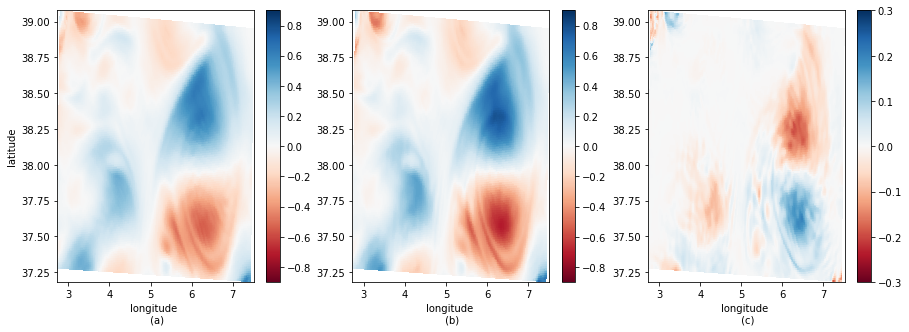

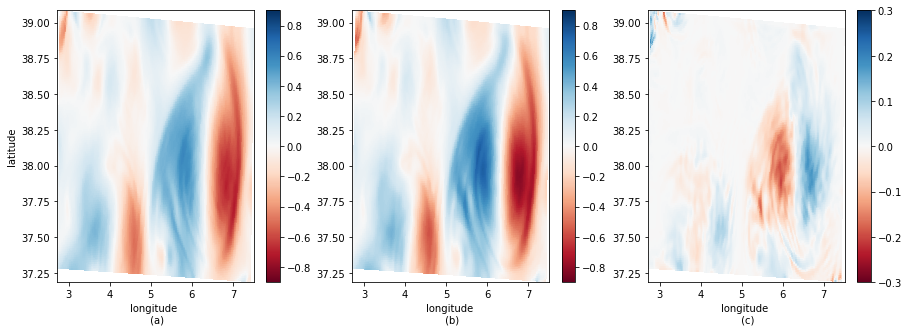

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, u_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,u_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_u, lat_u,u_geos-u_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_v, lat_v, v_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,v_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_v, lat_v,v_geos-v_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

## Ploting u v from eNATL60 and u_min v_min

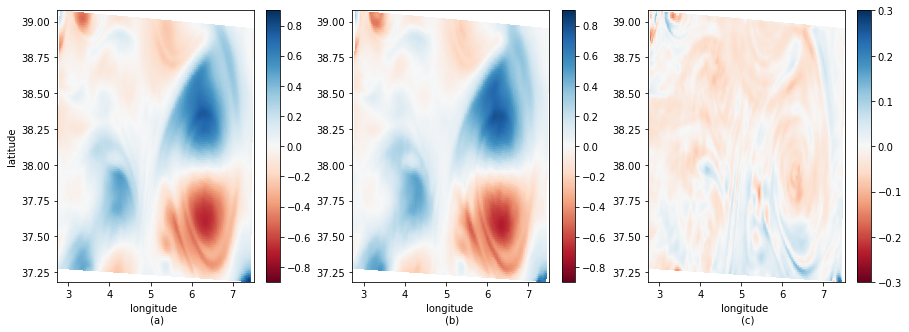

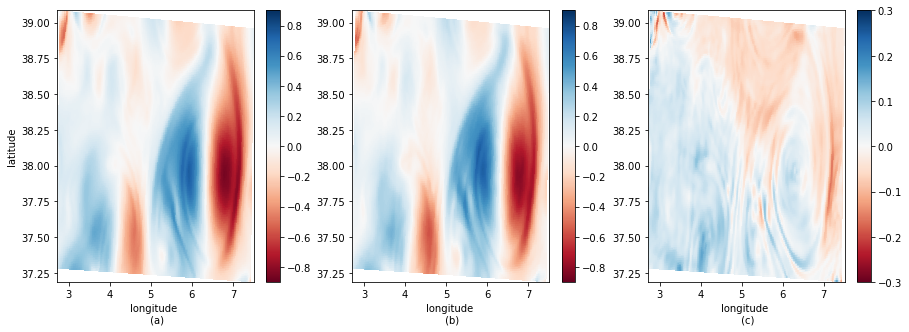

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,u_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_u, lat_u,uvel-u_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_v, lat_v, vvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,v_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_v, lat_v,vvel-v_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

## Comparing the differences

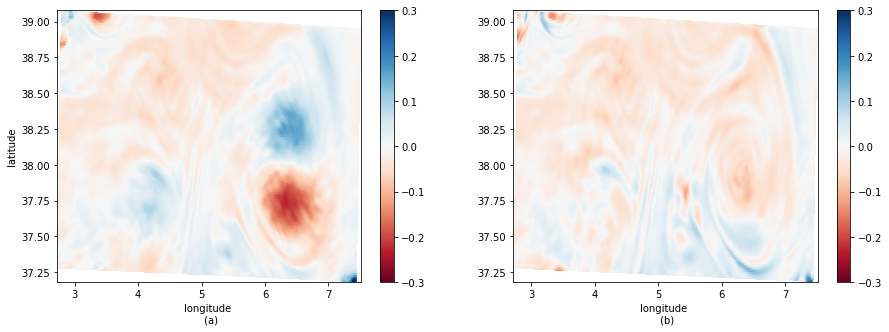

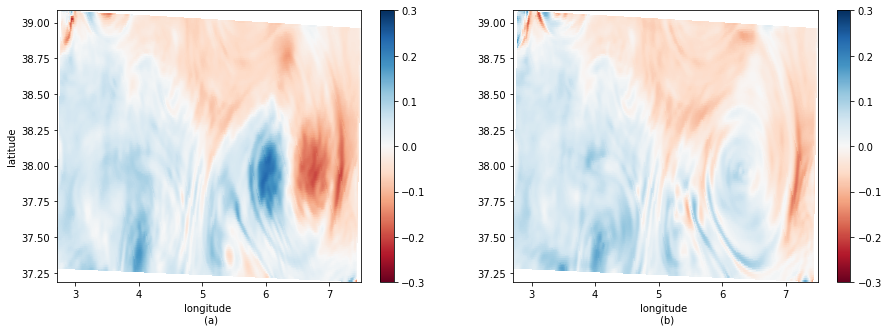

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel-u_geos, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,uvel-u_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_v, lat_v, vvel-v_geos, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,vvel-v_min, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax2)

## Computing the cyclogeostrophy - Iterative method

In [24]:
u_it, v_it = cyclo.cyclogeostrophy(u, v, coriolis_factor_u,coriolis_factor_v, lon_u, lat_u, lon_v, lat_v, 0.0001)

(1, (16933,), 0.059662294)
(2, (40469,), 0.0)


## Ploting the interative vs minimization cyclogestrophy

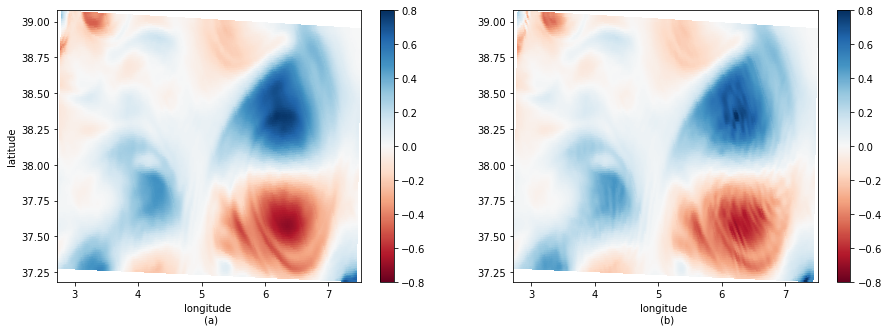

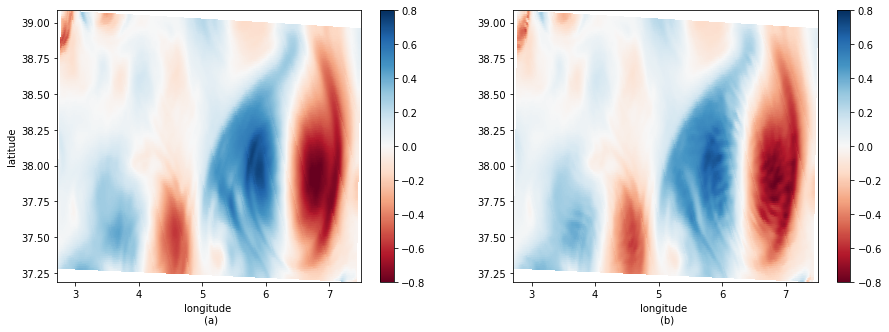

In [25]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, u_min, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,u_it, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_v, lat_v, v_min, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,v_it, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax2)

## Ploting the difference between cyclogestrophy methods

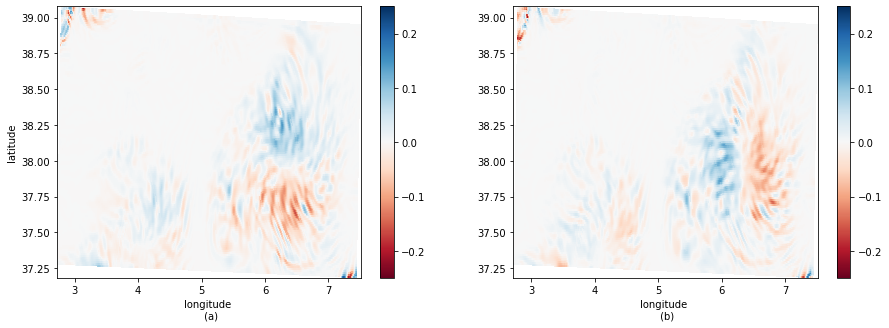

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, u_min-u_it, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,v_min-v_it, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax2)

## Ploting the difference between methods compared to the eNATL60 data

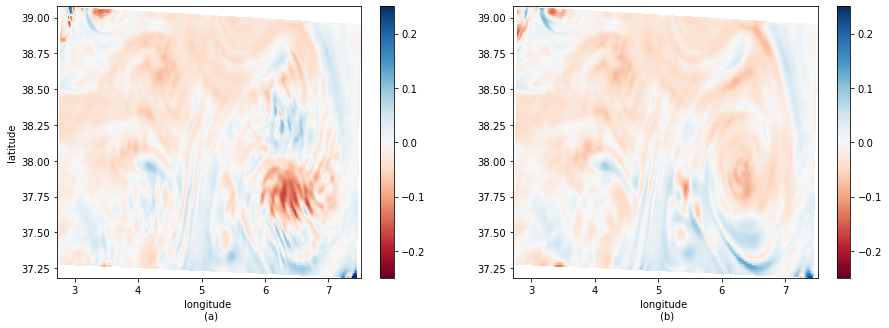

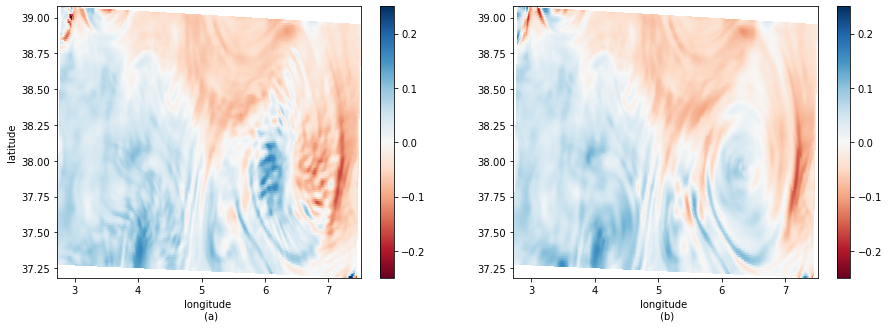

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel-u_it, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,uvel-u_min, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, vvel-v_it, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,vvel-v_min, cmap='RdBu',shading='auto',vmin=-0.25, vmax=0.25)
plt.colorbar(im,ax=ax2)